# Time Series Model for Monthly Sales of French Champagne Using Python
### David Lowe
### February 6, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

Code Credit: Adapted from a blog post made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

PREFACE: This is a replication of Python code from Dr. Brownlee's blog post on time series. I have combined all the code snippets into one script so that I can turn the whole process into a template. The comments and analysis were also part of the blog post and annotated here to explain each coding block.

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Monthly Sales of French Champagne dataset is a time series situation where we are trying to forecast future outcomes based on the past data points.

INTRODUCTION: The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France). The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data. The values are a count of millions of sales and there are 105 observations. The dataset is credited to Makridakis and Wheelwright, 1989.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 3186.501. The manually configured model was simplified to ARIMA(1,1,1) and produced an RMSE of 956.958, which is dramatically better than the persistence RMSE of 3186.501. After applying the grid search technique to the dataset, the final RMSE of the ARIMA(0,0,1) model was 939.464, which is slightly lower than the manually configured ARIMA from the previous section. This difference may or may not be statistically significant. At the end, we selected ARIMA(0,0,1) as the final model.

CONCLUSION: The final RMSE for the validation period is predicted at 361 million sales. This is much better than the expectation of an error of a little more than 924 million sales per month. At this scale on the plot, the 12 months of forecast sales figures look fantastic.

Dataset Used: Monthly Sales of French Champagne

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://datamarket.com/data/set/22r5/perrin-freres-monthly-champagne-sales-millions-64-72#!ds=22r5&display=line

One potential source of performance benchmark: https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize and Deploy Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
import numpy
import pandas
import smtplib
import warnings
from datetime import datetime
from email.message import EmailMessage
from math import exp
from math import log
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

# Create a random seed number variable for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Program Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore we will pretend that it is September 1971 and withhold the last one year of data from analysis and model selection. This final year of data will be used to validate the final model.

The code below will load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv). The specific contents of these files are:

* dataset.csv: Observations from January 1964 to September 1971 (93 observations)
* validation.csv: Observations from October 1971 to September 1972 (12 observations)

The validation dataset is about 11% of the original dataset.

In [4]:
startTimeScript = datetime.now()

In [5]:
# separate out a validation dataset
series = read_csv('champagne.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


### 1.d) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

* The first 50% of the dataset will be held back to train the model.
* The remaining 50% of the dataset will be iterated and test the model.
* For each step in the test dataset:
    * A model will be trained.
    * A one-step prediction made and the prediction stored for later evaluation.
    * The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

In [6]:
# evaluate persistence model on time series
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=5428.000, Expected=8314
>Predicted=8314.000, Expected=10651
>Predicted=10651.000, Expected=3633
>Predicted=3633.000, Expected=4292
>Predicted=4292.000, Expected=4154
>Predicted=4154.000, Expected=4121
>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2

In [7]:
email_notify("Program Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [8]:
email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with. Some observations from these statistics include:

* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 4,641, which we might consider our level in this series.
* The standard deviation (average spread from the mean) is relatively large at 2,486 sales.
* The percentiles along with the standard deviation do suggest a large spread to the data.

In [9]:
# summary statistics of time series
print(series.describe())

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: 1, dtype: float64


### 2.b) Line Plot

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot include:

* There may be an increasing trend of sales over time.
* There appears to be systematic seasonality to the sales for each year.
* The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
* There do not appear to be any obvious outliers.
* The seasonality suggests that the series is almost certainly non-stationary.

There may be benefit in explicitly modeling the seasonal component and removing it. We may also explore using differencing with one or two levels in order to make the series stationary. In addition, the increasing trend or growth in the seasonal component may suggest the use of a log or other power transform.

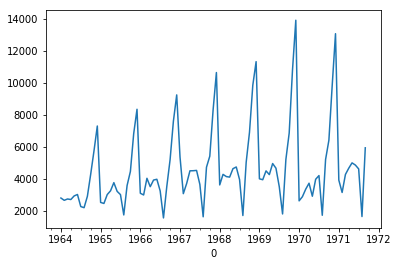

In [10]:
# line plots of time series
series.plot()
pyplot.show()

### 2.c) Seasonal Line Plots

We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year. The example below takes the 7 full years of data as separate groups and creates one line plot for each. The line plots are aligned vertically to help spot any year-to-year pattern.

We can clearly see a dip each August and a rise from each August to December. This pattern appears the same each year, although at different levels. This will help with any explicitly season-based modeling later.

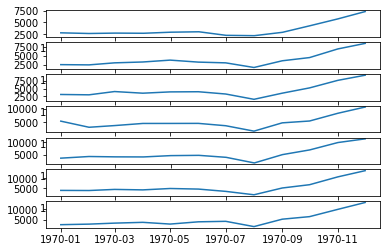

In [11]:
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

### 2.d) Density Plots

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots include:

* The distribution is not Gaussian.
* The shape has a long right tail and may suggest an exponential distribution.

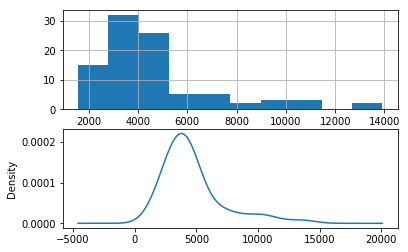

In [12]:
# density plots of time series
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

### 2.e) Box and Whisker Plots

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing. We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.

The example below groups the observations by year and creates one box and whisker plot for each year of observations. The last year (1971) only contains 9 months and may not be a useful comparison with the 12 months of observations for other years. Therefore, only data between 1964 and 1970 was plotted.

Some observations from reviewing the plot include:

* The median values for each year (red line) may show an increasing trend.
* The spread or middle 50% of the data (blue boxes) does appear reasonably stable.
* There are outliers each year (black crosses); these may be the tops or bottoms of the seasonal cycle.
* The last year, 1970, does look different from the trend in prior years.

The observations suggest perhaps some growth trend over the years and outliers that may be a part of the seasonal cycle. This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year.

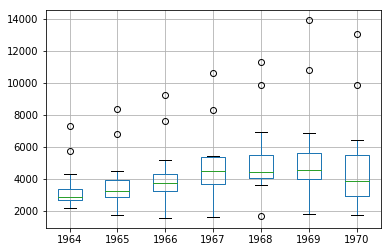

In [13]:
# boxplots of time series
groups = series['1964':'1970'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

In [14]:
email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Clean and Pre-Process Data

This section currently is not applicable to this iteration of the project.

In [15]:
email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [16]:
email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Manually Configure the ARIMA.
* Automatically Configure the ARIMA.
* Review Residual Errors.

In [17]:
email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Manually Configured ARIMA

In [18]:
email_notify("Performing Manual ARIMA has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

#### 4.a.i) Create Stationary Version of Time Series

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series.

The time series is almost certainly non-stationary. We can make it stationary this by first differencing the series and using a statistical test to confirm that the result is stationary.

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling.

We will use this dataset as an input to the ARIMA model. It also suggests that no further differencing may be required, and that the d parameter may be set to 0.

ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	5%: -2.898
	10%: -2.586


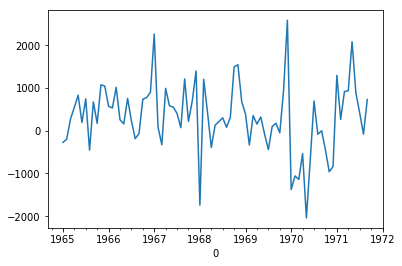

In [19]:
# create and summarize stationary version of time series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

#### 4.a.ii) ACF and PACF Plots

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Note, we are now using the seasonally differenced stationary.csv as our dataset.

Below are some observations from the plots.

* The ACF shows a significant lag for 1 month.
* The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
* Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values is also 1. The PACF plot also suggests that there is still some seasonality present in the differenced data.

We may consider a better model of seasonality, such as modeling it directly and explicitly removing it from the model rather than seasonal differencing.



C:\Users\david.lowe\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


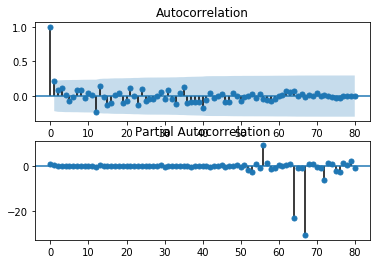

In [20]:
# ACF and PACF plots of time series
series = read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

#### 4.a.iii) Evaluate Manually Configured ARIMA Model

This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point.

The historic observations will be seasonally differenced prior to the fitting of each ARIMA model. The differencing will be inverted for all predictions made to make them directly comparable to the expected observation in the original sale count units.

Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of differencing to the stationary data made the model more stable. The model can be extended to ARIMA(1,1,1).

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant in the call to fit(). From experimentation, I find that this can result in better forecast performance on some problems.

Running this example results in an RMSE of 956.958, which is dramatically better than the persistence RMSE of 3186.501.

In [21]:
# evaluate manually configured ARIMA model
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=8089.799, Expected=8314
>Predicted=9742.807, Expected=10651
>Predicted=5986.917, Expected=3633
>Predicted=3886.768, Expected=4292
>Predicted=4038.107, Expected=4154
>Predicted=4992.354, Expected=4121
>Predicted=5156.490, Expected=4647
>Predicted=5046.652, Expected=4753
>Predicted=4143.802, Expected=3965
>Predicted=2102.971, Expected=1723
>Predicted=5228.276, Expected=5048
>Predicted=5873.366, Expected=6922
>Predicted=8571.395, Expected=9858
>Predicted=11005.988, Expected=11331
>Predicted=4087.481, Expected=4016
>Predicted=4771.840, Expected=3957
>Predicted=4676.087, Expected=4510
>Predicted=4583.393, Expected=4276
>Predicted=5117.354, Expected=4968
>Predicted=5208.152, Expected=4677
>Predicted=4436.430, Expected=3523
>Predicted=2180.851, Expected=1821
>Predicted=5471.221, Expected=5222
>Predicted=7337.589, Expected=6872
>Predicted=10268.338, Expected=10803
>Predicted=11725.346, Expected=13916
>Predicted=4519.433, Expected=2639
>Predicted=4606.066, Expected=2899
>Predicted=49

In [22]:
email_notify("Performing Manual ARIMA completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.b) Grid Search of ARIMA Hyperparameters

The ACF and PACF plots suggest that an ARIMA(1,0,1) or similar may be the best that we can do.

To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

p: 0 to 6.
d: 0 to 2.
q: 0 to 6.
This is (7 * 3 * 7), or 147, potential runs of the test harness and will take some time to execute.

It may be interesting to evaluate MA models with a lag of 12 or 13 as were noticed as potentially interesting from reviewing the ACF and PACF plots. Experimentation suggested that these models may not be stable, resulting in errors in the underlying mathematical libraries.

The results show that the best configuration discovered was ARIMA(0, 0, 1) with an RMSE of 939.464, slightly lower than the manually configured ARIMA from the previous section. This difference may or may not be statistically significant. We will select this ARIMA(0, 0, 1) model going forward.

In [23]:
email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [24]:
# grid search ARIMA parameters for time series
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 0, 3) RMSE=944.237
ARIMA(0, 0, 4) RMSE=958.795
ARIMA(0, 0, 5) RMSE=986.834
ARIMA(0, 0, 6) RMSE=1087.014
ARIMA(0, 1, 1) RMSE=958.301
ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.958
ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134
ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.956
ARIMA(2, 2, 0) RMSE=1346.598
ARIMA(2, 2, 1) RMSE=1039.657
ARIMA(3, 0, 0) RMSE=959.165
ARIMA(3, 1, 0) RMSE=1028.226
ARIMA(3, 1, 1) RMSE=979.940
ARIMA(3, 2, 0) RMSE=1244.846
ARIMA(4, 0, 0) RMSE=968.411
ARIMA(4, 1, 0) RMSE=1046.524
ARIMA(4, 1, 1) RMSE=1006.260
ARIMA(4, 2, 0) RMSE=1227.555
ARIMA(4, 2, 1) RMSE=1055.485
ARIMA(5, 0, 0) RMSE=987.690
ARIMA(5, 1, 0) RMSE=1042.642
ARIMA(5, 1, 1) RMSE=1023.399
ARIMA(5, 2, 1) RMSE=1053.745
ARIMA(6, 0, 0) RMSE=996.466
ARIMA(6, 1, 0) RMSE=1018.211
ARIMA(6, 1, 1) RMSE=1023.760
ARIMA(6, 1, 2) RMSE=1033.406
Best ARIMA(0, 0, 1) RMSE=939.

In [25]:
email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(0, 0, 1) model.

We can see that the distribution has a right shift and that the mean is non-zero at 165.904728. This is perhaps a sign that the predictions are biased.

The graphs suggest a Gaussian-like distribution with a bumpy left tail, providing further evidence that perhaps a power transform might be worth exploring.

In [26]:
email_notify("Residual Errors Review has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

                 0
count    47.000000
mean    165.904730
std     934.696204
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     732.992187
max    2367.304815


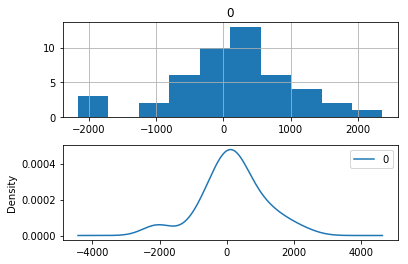

In [27]:
# summarize ARIMA forecast residuals
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

We could use this information to bias-correct predictions by adding the mean residual error of 165.904730 to each forecast made.

The performance of the predictions is improved very slightly from 939.464 to 924.699, which may or may not be significant. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

Finally, density plots of the residual error do show a small shift towards zero. It is debatable whether this bias correction is worth it, but we will use it for now.

RMSE: 924.699
                  0
count  4.700000e+01
mean   4.450881e-07
std    9.346962e+02
min   -2.330152e+03
25%   -4.555563e+02
50%    2.585482e+01
75%    5.670875e+02
max    2.201400e+03


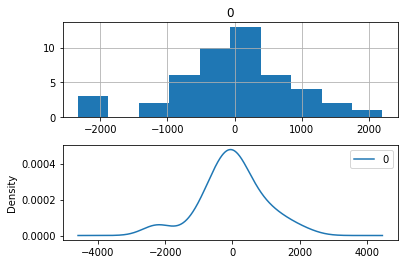

In [28]:
# plots of residual errors of bias corrected forecasts
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 165.904730
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

The results suggest that what little autocorrelation is present in the time series has been captured by the model.

                 0
count    47.000000
mean    165.904730
std     934.696204
min   -2164.247449
25%    -289.651596
50%     191.759548
75%     732.992187
max    2367.304815


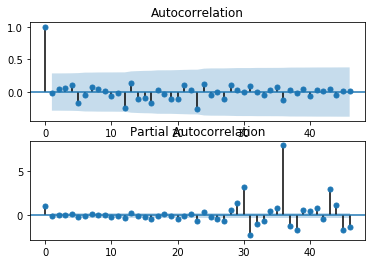

In [29]:
# ACF and PACF plots of residual errors of bias corrected forecasts
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [30]:
email_notify("Residual Errors Review completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize and Deploy Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

* Finalize Model: Train and save the final model.
* Make Prediction: Load the finalized model and make a prediction.
* Validate Model: Load and validate the final model.

In [32]:
email_notify("Model Finalization and Deployment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case on a transformed version of the entire dataset. Once fit, the model can be saved to file for later use.

The code below trains an ARIMA(0,0,1) model on the dataset and saves the whole fit object and the bias to file. Running the code creates two local files:

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
* model_bias.npy This is the bias value stored as a one-row, one-column NumPy array.

In [33]:
# save finalized model
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 165.904730
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

### 5.b) Make Prediction

A natural case may be to load the model and make a single forecast. This is relatively straightforward and involves restoring the saved model and the bias and calling the forecast() function.

Running the example prints the prediction of about 6794. If we peek inside validation.csv, we can see that the value on the first row for the next time period is 6981.

In [34]:
# load finalized model and make a prediction
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

months_in_year = 12
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 6794.773


### 5.c) Validate Model

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model. We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

There are two ways we might proceed:

* Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
* Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice as it would achieve the best performance.

As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

The final RMSE for the validation period is predicted at 361.110 million sales. This is much better than the expectation of an error of a little more than 924 million sales per month. At this scale on the plot, the 12 months of forecast sales figures look fantastic.

>Predicted=6794.773, Expected=6981
>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 361.110


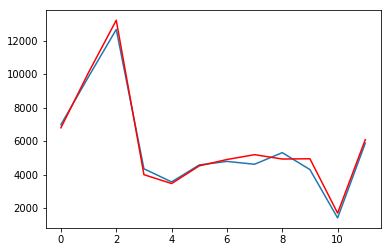

In [35]:
# load and evaluate the finalized model on the validation dataset
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# Prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(0,0,1))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

In [36]:
email_notify("Model Finalization and Deployment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:49.094818
